# ASSIGNMENT 2 
This assignment was performed by Giorgia Castelli, Alice Fratini and Mone Madalina Ionela.

This notebook addresses the Human Value Detection task, a multi-label classification problem aimed at identifying the human values conveyed in arguments structured as pairs of premise and conclusion. The analysis leverages transformer models, specifically BERT, to accurately associate arguments with the human values they express.

Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#models
import torch
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

#metrics
from sklearn.metrics import classification_report, multilabel_confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from scipy.stats import mode

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device: {device}")

## Task 1 - Corpus

Loading and merging annotations to level 3 categories.

In [2]:
def load_and_merge_data():
    
    #encodng the data into pandas.DataFrame objects
    url_a_test = 'Data/arguments-test.tsv'
    df_a_test = pd.read_csv(url_a_test, sep='\t')

    url_a_training = 'Data/arguments-training.tsv'
    df_a_training = pd.read_csv(url_a_training, sep='\t')

    url_a_validation = 'Data/arguments-validation.tsv'
    df_a_validation = pd.read_csv(url_a_validation, sep='\t')

    url_l_test = 'Data/labels-test.tsv'
    df_l_test = pd.read_csv(url_l_test, sep='\t')

    url_l_training = 'Data/labels-training.tsv'
    df_l_training = pd.read_csv(url_l_training, sep='\t')

    url_l_validation = 'Data/labels-validation.tsv'
    df_l_validation = pd.read_csv(url_l_validation, sep='\t')

    #merge argument dataframes with label dataframes
    df_test = pd.merge(df_a_test, df_l_test, on='Argument ID')
    df_training = pd.merge(df_a_training, df_l_training, on='Argument ID')
    df_validation = pd.merge(df_a_validation, df_l_validation, on='Argument ID')

    return df_test, df_training, df_validation

In [3]:
df_test, df_training, df_validation = load_and_merge_data()

In [4]:
def merge_and_drop_columns(df):
    # Merge level 2 annotations to level 3 categories taking in consideration the shared categories
    df['Openess to change'] = df[['Self-direction: thought', 'Self-direction: action', 'Stimulation', 'Hedonism']].any(axis=1).astype(int)
    df['Self-enhancement'] = df[['Hedonism', 'Achievement', 'Power: dominance', 'Power: resources', 'Face']].any(axis=1).astype(int)
    df['Conservation'] = df[['Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal', 'Humility']].any(axis=1).astype(int)
    df['Self-transcendence'] = df[['Humility', 'Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature', 'Universalism: tolerance', 'Universalism: objectivity']].any(axis=1).astype(int)
    
    # Drop unuseful columns
    columns_to_drop = ['Argument ID', 'Self-direction: thought', 'Self-direction: action', 'Stimulation', 'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources', 'Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal', 'Humility', 'Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature', 'Universalism: tolerance', 'Universalism: objectivity']
    df = df.drop(columns=columns_to_drop)
    
    return df

df_test = merge_and_drop_columns(df_test)
df_training = merge_and_drop_columns(df_training)
df_validation = merge_and_drop_columns(df_validation)


In [5]:
df_test.head()

,Conclusion,Stance,Premise,Openess to change,Self-enhancement,Conservation,Self-transcendence
0,We should end affirmative action,against,affirmative action helps with employment equity.,0,1,1,1
1,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,0,1,0,1
2,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,0,1,1,1
3,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,0,1,0,0
4,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,0,1,1,1


### DATA EXPLORATION

We explore the distribution of 'Conclusion' column length in the three datasets: the vast majority of the rows have len < 100.

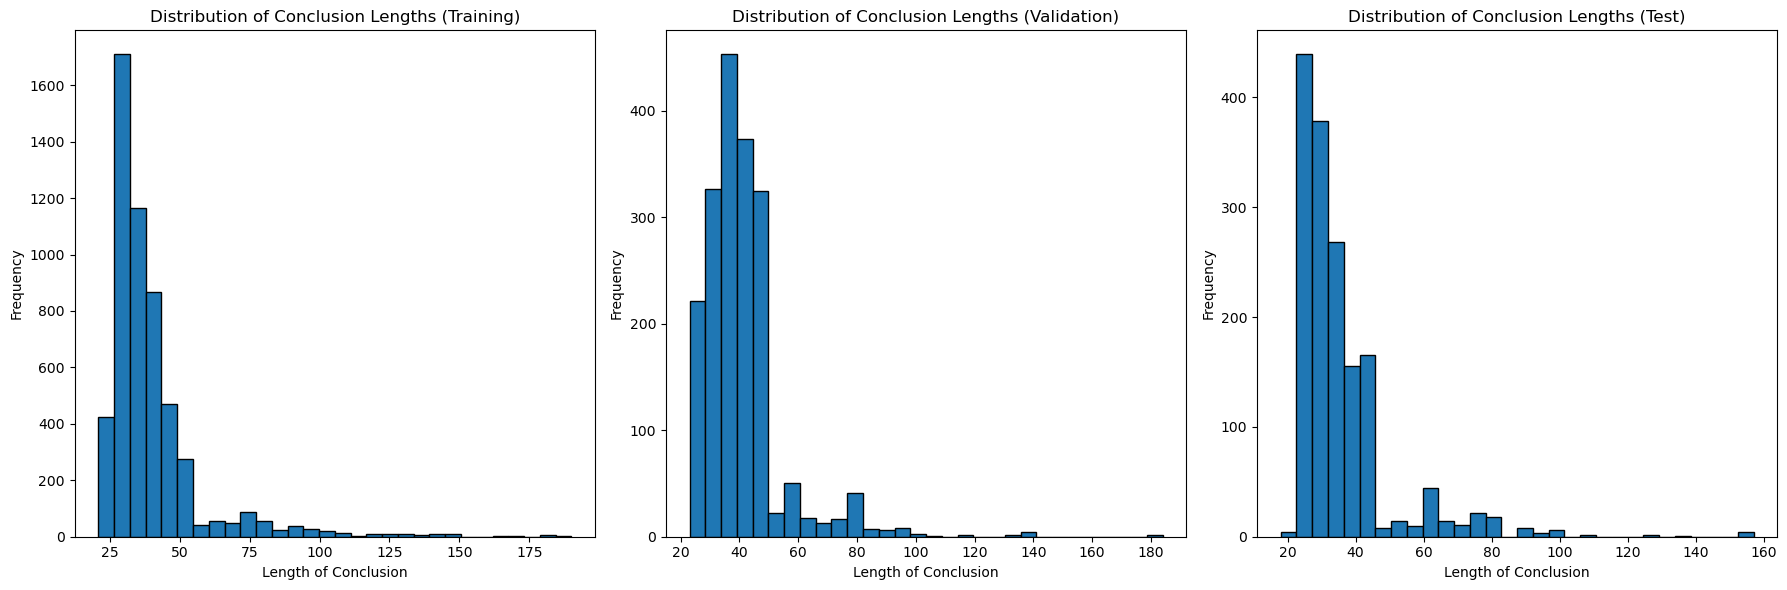

In [6]:
df_training['Conclusion_Length'] = df_training['Conclusion'].apply(len)
df_validation['Conclusion_Length'] = df_validation['Conclusion'].apply(len)
df_test['Conclusion_Length'] = df_test['Conclusion'].apply(len)

# Plot the distribution of the lengths for each DataFrame
plt.figure(figsize=(18, 6))

# Plot for df_training
plt.subplot(1, 3, 1)
plt.hist(df_training['Conclusion_Length'], bins=30, edgecolor='black')
plt.title('Distribution of Conclusion Lengths (Training)')
plt.xlabel('Length of Conclusion')
plt.ylabel('Frequency')

# Plot for df_validation
plt.subplot(1, 3, 2)
plt.hist(df_validation['Conclusion_Length'], bins=30, edgecolor='black')
plt.title('Distribution of Conclusion Lengths (Validation)')
plt.xlabel('Length of Conclusion')
plt.ylabel('Frequency')

# Plot for df_test
plt.subplot(1, 3, 3)
plt.hist(df_test['Conclusion_Length'], bins=30, edgecolor='black')
plt.title('Distribution of Conclusion Lengths (Test)')
plt.xlabel('Length of Conclusion')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Then we explore the distribution of 'Premise' column length in the three datasets.

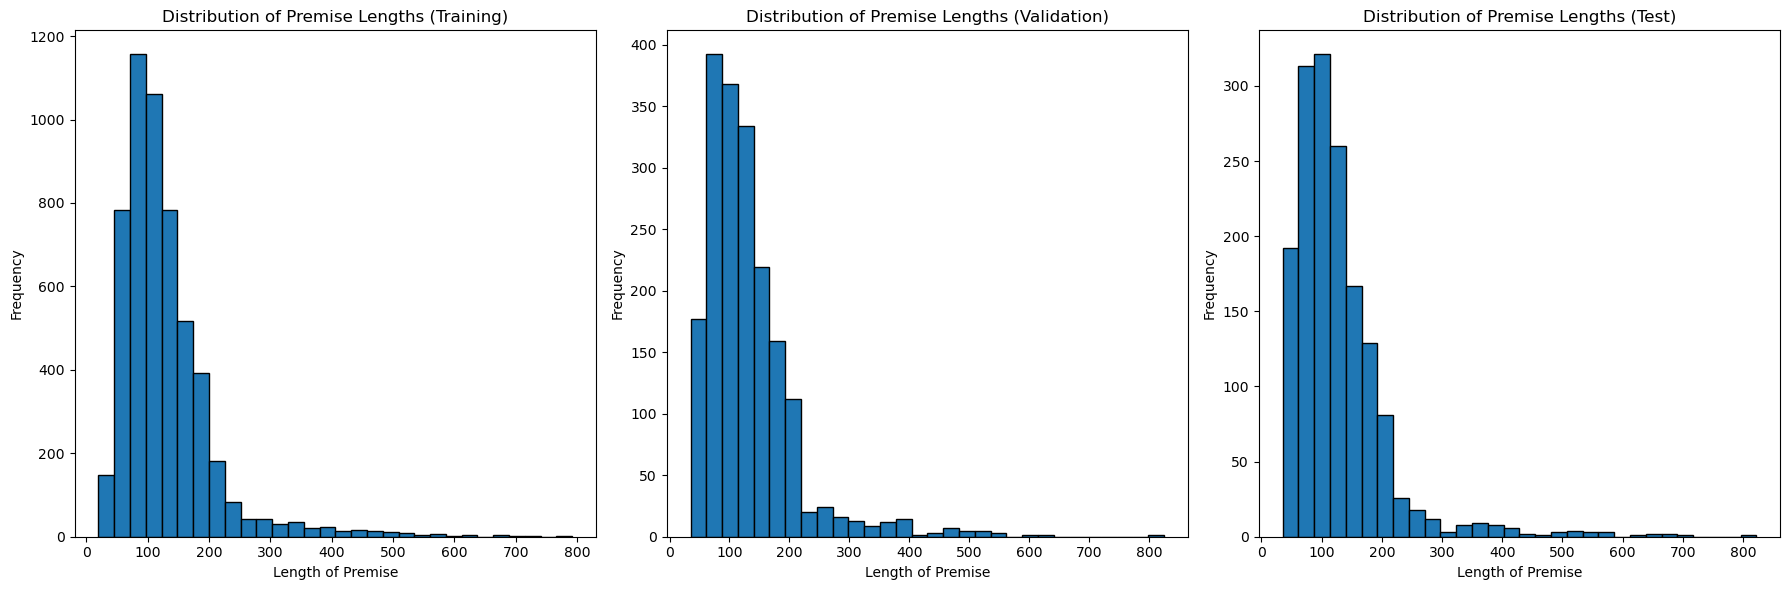

In [7]:
df_training['Premise_Length'] = df_training['Premise'].apply(len)
df_validation['Premise_Length'] = df_validation['Premise'].apply(len)
df_test['Premise_Length'] = df_test['Premise'].apply(len)

# Plot the distribution of the lengths for each DataFrame
plt.figure(figsize=(18, 6))

# Plot for df_training
plt.subplot(1, 3, 1)
plt.hist(df_training['Premise_Length'], bins=30, edgecolor='black')
plt.title('Distribution of Premise Lengths (Training)')
plt.xlabel('Length of Premise')
plt.ylabel('Frequency')

# Plot for df_validation
plt.subplot(1, 3, 2)
plt.hist(df_validation['Premise_Length'], bins=30, edgecolor='black')
plt.title('Distribution of Premise Lengths (Validation)')
plt.xlabel('Length of Premise')
plt.ylabel('Frequency')

# Plot for df_test
plt.subplot(1, 3, 3)
plt.hist(df_test['Premise_Length'], bins=30, edgecolor='black')
plt.title('Distribution of Premise Lengths (Test)')
plt.xlabel('Length of Premise')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Finally, we explore the distribution of 'Stance' column: only two values appear in in this column. This observation justifies the numerical encoding of this column into 1 and 0. 
The distribution is slightly imbalanced for the value 'in favor of'. 

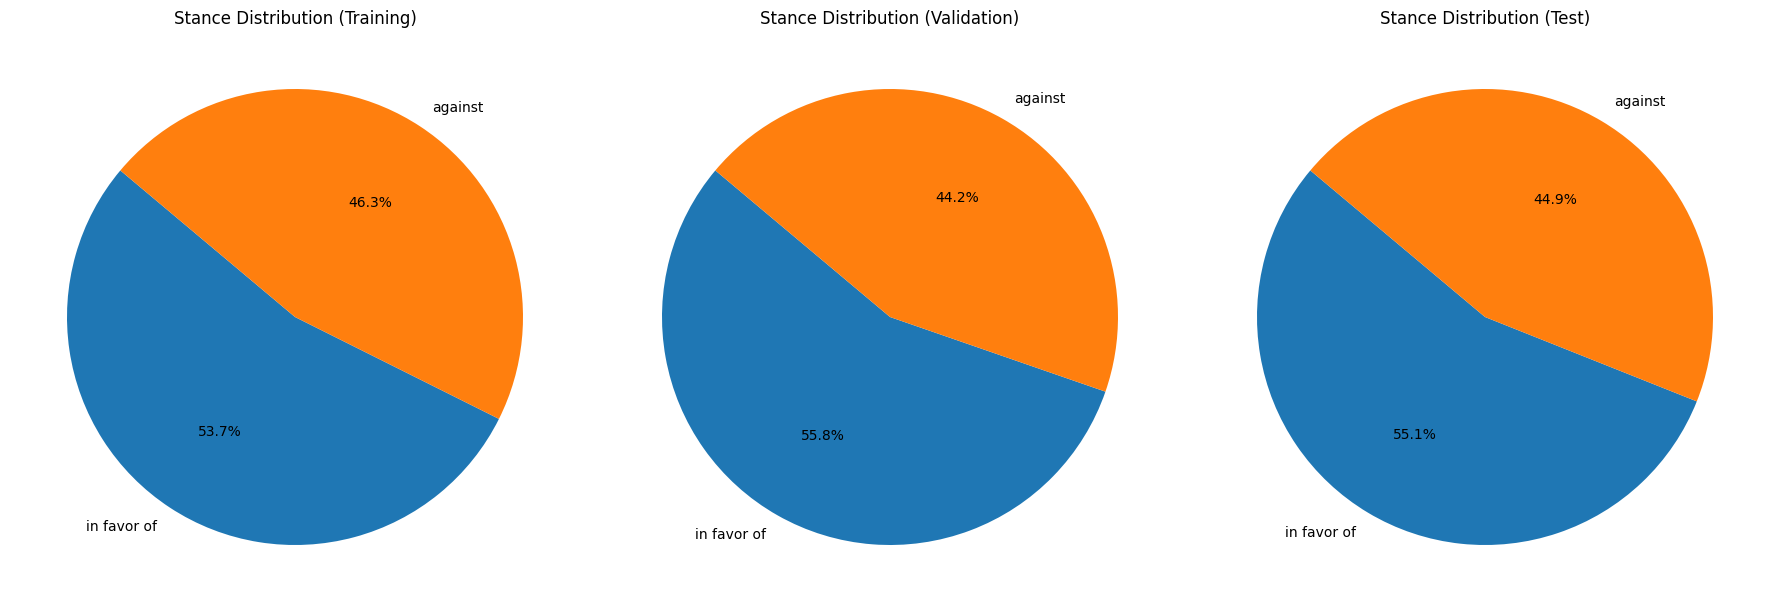

In [9]:
# Calculate the distribution of the 'Stance' column
stance_distribution_training = df_training['Stance'].value_counts()
stance_distribution_validation = df_validation['Stance'].value_counts()
stance_distribution_test = df_test['Stance'].value_counts()

# Plot the pie charts
plt.figure(figsize=(18, 6))

# Pie chart for df_training
plt.subplot(1, 3, 1)
plt.pie(stance_distribution_training, labels=stance_distribution_training.index, autopct='%1.1f%%', startangle=140)
plt.title('Stance Distribution (Training)')

# Pie chart for df_validation
plt.subplot(1, 3, 2)
plt.pie(stance_distribution_validation, labels=stance_distribution_validation.index, autopct='%1.1f%%', startangle=140)
plt.title('Stance Distribution (Validation)')

# Pie chart for df_test
plt.subplot(1, 3, 3)
plt.pie(stance_distribution_test, labels=stance_distribution_test.index, autopct='%1.1f%%', startangle=140)
plt.title('Stance Distribution (Test)')

plt.tight_layout()
plt.show()

At the end we explore the distribution of the four categories in the datasets.

As we can see the most represented categories are: 'Self-transcendence' and 'Conservation' in all three datasets.

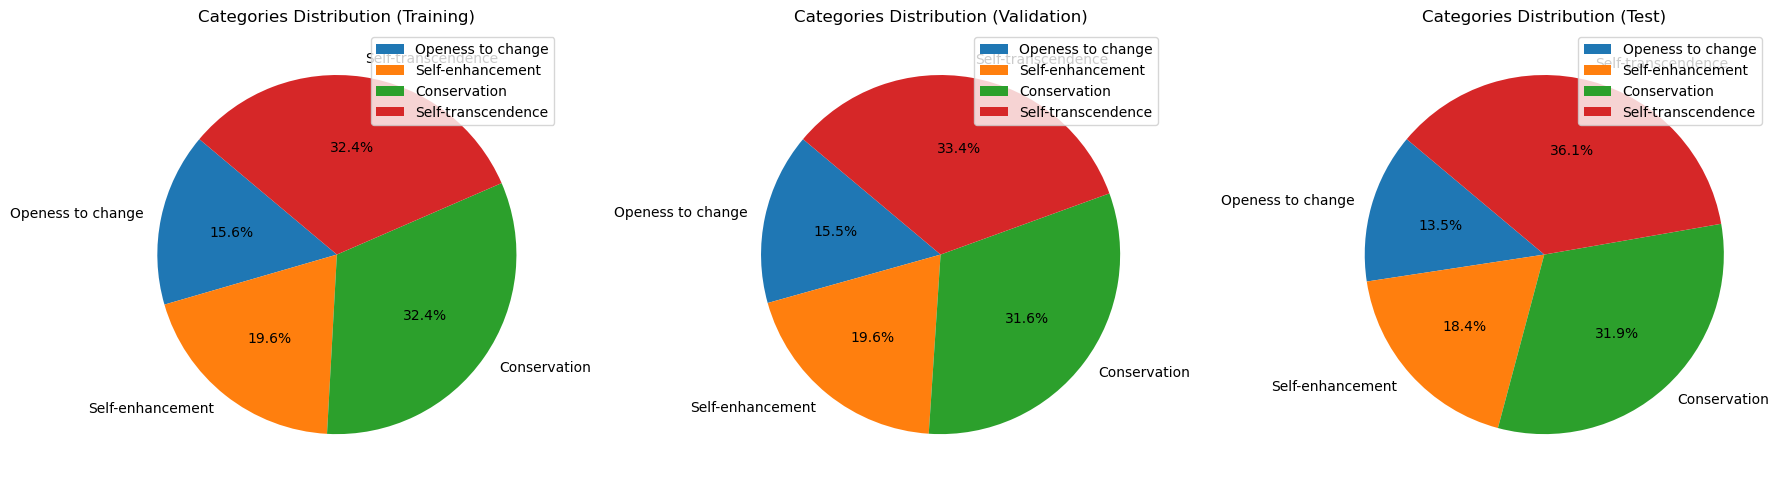

In [8]:
# Calculate the sum of the specified columns for each row
df_training['Values_Sum'] = df_training[['Openess to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']].sum(axis=1)
df_validation['Values_Sum'] = df_validation[['Openess to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']].sum(axis=1)
df_test['Values_Sum'] = df_test[['Openess to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']].sum(axis=1)

# Calculate the distribution of the categories set to 1
labels_distribution_training = df_training[['Openess to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']].sum()
labels_distribution_validation = df_validation[['Openess to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']].sum()
labels_distribution_test = df_test[['Openess to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']].sum()

# Plot the pie charts
plt.figure(figsize=(18, 6))

# Pie chart for df_training
plt.subplot(1, 3, 1)
patches, texts, autotexts = plt.pie(labels_distribution_training, labels=labels_distribution_training.index, autopct='%1.1f%%', startangle=140)
plt.title('Categories Distribution (Training)')
plt.legend(patches, labels_distribution_training.index, loc="best")

# Pie chart for df_validation
plt.subplot(1, 3, 2)
patches, texts, autotexts = plt.pie(labels_distribution_validation, labels=labels_distribution_validation.index, autopct='%1.1f%%', startangle=140)
plt.title('Categories Distribution (Validation)')
plt.legend(patches, labels_distribution_validation.index, loc="best")

# Pie chart for df_test
plt.subplot(1, 3, 3)
patches, texts, autotexts = plt.pie(labels_distribution_test, labels=labels_distribution_test.index, autopct='%1.1f%%', startangle=140)
plt.title('Categories Distribution (Test)')
plt.legend(patches, labels_distribution_test.index, loc="best")

plt.tight_layout()
plt.show()

### DATA PREPROCESSING

Encoding 'Stance' column into numerical format.

In [ ]:
df_test['Stance'] = df_test['Stance'].replace({'in favor of': 1, 'against': 0}).astype(str)
df_training['Stance'] = df_training['Stance'].replace({'in favor of': 1, 'against': 0}).astype(str)
df_validation['Stance'] = df_validation['Stance'].replace({'in favor of': 1, 'against': 0}).astype(str)

Preparing data for tokenization input.

In [ ]:
labels_test = df_test.iloc[:, 3:7].values
labels_training = df_training.iloc[:, 3:7].values
labels_validation = df_validation.iloc[:, 3:7].values

stance_test = df_test['Stance'].values
stance_training = df_training['Stance'].values
stance_validation = df_validation['Stance'].values

#### BERT Dataset Creation

In this section, we define a custom dataset class `BertDatasetCreator` for preparing data to be fed into a BERT model. We use the `AutoTokenizer` from the Hugging Face `transformers` library to tokenize the input text. The class takes in a DataFrame data, labels, a tokenizer, and a maximum sequence length as inputs. It implements the `__len__` method to return the number of samples and the `__getitem__` method to retrieve a tokenized sample along with its corresponding label. The `__getitem__` method uses the tokenizer to encode the text, adding special tokens, padding to the maximum length, and truncating if necessary. It returns a dictionary containing the input IDs, attention masks, token type IDs, and labels as tensors.

In [13]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 100

class BertDatasetCreator(Dataset):
    def __init__(self, data, labels, tokenizer, max_length):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = str(self.data[idx])
        item = ' '.join(item.split())
        
        encoded_dict = self.tokenizer.encode_plus(
            item,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
        )
        input_ids = encoded_dict['input_ids']
        attention_masks = encoded_dict['attention_mask']
        token_type_ids = encoded_dict['token_type_ids']

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_masks, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

#### Creating Datasets and DataLoaders

In this section, we create datasets and dataloaders for the test, training, and validation sets. We use the `BertDatasetCreator` class to create datasets by concatenating the 'Conclusion' and 'Premise' columns for each set and passing the resulting text along with the labels, tokenizer, and maximum sequence length. 

We then create dataloaders for each dataset using the `DataLoader` class from PyTorch, specifying a 16 batch size. 
These dataloaders will be used to efficiently feed data into the BERT model during training and evaluation.

##### BERT w/C dataset

In [14]:
BATCH_SIZE = 16

test_dataset_c = BertDatasetCreator(df_test['Conclusion'], labels_test, tokenizer, MAX_LENGTH)
train_dataset_c = BertDatasetCreator(df_training['Conclusion'], labels_training, tokenizer, MAX_LENGTH)
val_dataset_c = BertDatasetCreator(df_validation['Conclusion'], labels_validation, tokenizer, MAX_LENGTH)

test_dataloader_c = DataLoader(test_dataset_c, batch_size=BATCH_SIZE)
train_dataloader_c = DataLoader(train_dataset_c, batch_size=BATCH_SIZE)
val_dataloader_c = DataLoader(val_dataset_c, batch_size=BATCH_SIZE)

##### BERT w/CP

In [16]:
test_dataset_cp = BertDatasetCreator(df_test['Conclusion'] + ' ' + df_test['Premise'], labels_test, tokenizer, MAX_LENGTH)
train_dataset_cp = BertDatasetCreator(df_training['Conclusion'] + ' ' + df_training['Premise'], labels_training, tokenizer, MAX_LENGTH)
val_dataset_cp = BertDatasetCreator(df_validation['Conclusion'] + ' ' + df_validation['Premise'], labels_validation, tokenizer, MAX_LENGTH)

test_dataloader_cp = DataLoader(test_dataset_cp, batch_size=BATCH_SIZE)
train_dataloader_cp = DataLoader(train_dataset_cp, batch_size=BATCH_SIZE)
val_dataloader_cp = DataLoader(val_dataset_cp, batch_size=BATCH_SIZE)

##### BERT w/CPS

In [17]:
test_dataset_cps = BertDatasetCreator(df_test['Conclusion'] + ' ' + df_test['Premise'] + ' ' + df_test['Stance'], labels_test, tokenizer, MAX_LENGTH)
train_dataset_cps = BertDatasetCreator(df_training['Conclusion'] + ' ' + df_training['Premise'] + ' ' + df_training['Stance'], labels_training, tokenizer, MAX_LENGTH)
val_dataset_cps = BertDatasetCreator(df_validation['Conclusion'] + ' ' + df_validation['Premise'] + ' ' + df_validation['Stance'], labels_validation, tokenizer, MAX_LENGTH)

test_dataloader_cps = DataLoader(test_dataset_cps, batch_size=BATCH_SIZE)
train_dataloader_cps = DataLoader(train_dataset_cps, batch_size=BATCH_SIZE)
val_dataloader_cps = DataLoader(val_dataset_cps, batch_size=BATCH_SIZE)

## Task 2 - Models Definitions

### Creating Random Uniform and Majority Classifiers

In this section, we define two types of classifiers: a random uniform classifier and a majority classifier. 

1. **Random Uniform Classifier**: The `create_random_uniform_classifier` function creates a classifier that randomly assigns a label (0 or 1) with equal probability. This classifier is useful as a baseline to compare against more sophisticated models.

2. **Majority Classifier**: The `create_majority_classifier` function creates a classifier that always predicts the most frequent label (mode) found in the training data for a given category. This classifier is another baseline that leverages the most common outcome in the training set.

We then create these classifiers for each of the specified categories (`'Openess to change'`, `'Self-enhancement'`, `'Conservation'`, `'Self-transcendence'`) and store them in a dictionary. Each classifier is named according to its type and the category it is associated with. This setup allows us to easily access and use these baseline classifiers for evaluation and comparison purposes.

In [18]:
def create_random_uniform_classifier(label):
    def random_uniform_classifier(size):
        return np.random.choice([0, 1], size=size)
    return random_uniform_classifier

In [19]:
def create_majority_classifier(label, train_data):
    #the maojority value is the mode value in the training data
    majority_value = train_data[label].mode()[0]
    def majority_classifier(size):
        return np.full(size, majority_value)
    return majority_classifier

In [20]:
classifiers = {}

labels = ['Openess to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']

#create classifiers for each category and save them in the dictionary
for label in labels:
    #random uniform classifier
    random_uniform_name = f'random_uniform_classifier_{label}'
    classifiers[random_uniform_name] = create_random_uniform_classifier(label)

    #majority classifier
    majority_name = f'majority_classifier_{label}'
    classifiers[majority_name] = create_majority_classifier(label, df_training)

### Defining and Initializing BERT Models

In this section, we define a custom BERT-based model class `Bert_Model` for multi-label classification. The class inherits from `torch.nn.Module` and includes the following components:

1. **BERT Model**: We use the `AutoModel` from the Hugging Face `transformers` library, specifically the 'bert-base-uncased' model pre-trained for multi-label classification with 4 labels.
2. **Dropout Layer**: A dropout layer with a probability of 0.3 to prevent overfitting.
3. **Classifier Layer**: A linear layer that maps the BERT hidden states to the 4 output labels.

The `forward` method defines the forward pass of the model, which includes:
- Passing the input through the BERT model to get the hidden states.
- Applying dropout to the hidden states.
- Passing the result through the classifier layer to get the final outputs.

We then instantiate three models (`c_model`, `cp_model`, and `cps_model`) using the `Bert_Model` class.

In [21]:
class Bert_Model(torch.nn.Module):
    def __init__(self):
        super(Bert_Model, self).__init__()
        self.bert = AutoModel.from_pretrained(
            pretrained_model_name_or_path= 'bert-base-uncased', 
            problem_type='multi_label_classification', 
            num_labels = 4, 
            return_dict=False)
        self.dropout = torch.nn.Dropout(p=0.3)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, 4)

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        outputs = self.dropout(outputs)
        outputs = self.classifier(outputs)
        return outputs

In [22]:
c_model = Bert_Model()
cp_model = Bert_Model()
cps_model = Bert_Model()

c_model.to(device)
cp_model.to(device)
cps_model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Bert_Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

## Task 3 - Metrics

### Calculating Baseline Models Metrics

In this section, we define two functions to evaluate and print the performance of baseline classifiers:

1. **`baseline_metrics` Function**: This function calculates the F1 scores for each label and the macro F1 score for the entire dataset. The function returns a dictionary containing them.

2. **`print_baseline_metrics` Function**: A simple function that prints the results.

These functions help in evaluating the performance of the baseline classifiers and provide a benchmark to compare against more sophisticated models.

In [23]:
def baseline_metrics(predicted_results, test_dataset, labels):
    f1_scores = {}
    binary_f1_scores = []
    for label in labels:
        true_values = test_dataset[label]
        predictions = predicted_results[label]
        f1 = f1_score(true_values, predictions, average='binary')
        f1 = round(f1, 2) #round to 2 decimal places
        f1_score_name = f'{label}'
        f1_scores[f1_score_name] = f1

        #binary f1 score for every category
        binary_f1 = f1_score(true_values, predictions, average='binary')
        binary_f1_scores.append(binary_f1)

    #macro f1 score
    macro_f1 = round(np.mean(binary_f1_scores), 2)
    f1_scores['Macro F1'] = macro_f1
    return f1_scores

In [24]:
def print_baseline_metrics(metrics, type):
    if type == 'random_uniform':
        classifier_type = 'Random Uniform'
    elif type == 'majority':
        classifier_type = 'Majority'
    print(f"Classifier Type: {classifier_type}")
    for label, score in metrics.items():
        print(f"{label}: {score}")

### Calculating BERT Models Metrics
In this section, we define a function `generate_classification_report` to evaluate the performance of a model on a test dataset and store the results in dictionaries for further analysis.

The function makes predictions, applies optimal thresholds, generates a classification report, extracts precision and recall, and computes confusion matrices. The results are stored in dictionaries for further analysis.

In [ ]:
classification_reports = {}
precision_recall = {}
confusion_matrixes = {}
y_preds = {}

def generate_classification_report(model, X_test, Y_test, thresholds):
    
    # Set the model to evaluation mode
    model.eval()
    Y_pred = []
    num_labels = len(thresholds)
    return_report = {}
    precision_recall_data = {str(i): {'precision': [], 'recall': []} for i in range(num_labels)}

    with torch.no_grad(): # Disable gradient tracking
        for _, batch in enumerate(X_test, 0):
            input_ids = batch['input_ids'].to(device, dtype = torch.long)
            attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            outputs = outputs.cpu().numpy() # Convert the outputs to a NumPy array

            # Apply the thresholds to the outputs
            preds = np.zeros_like(outputs)
            for i in range(num_labels):
                preds[:, i] = (outputs[:, i] > thresholds[i]).astype(int)
            Y_pred.extend(preds)
            
    Y_pred = np.array(Y_pred) # Convert the list of predictions to a NumPy array
    
    # Generate the classification report and confusion matrix
    report = classification_report(Y_test, Y_pred, zero_division=1, output_dict=True)
    conf_matrix = multilabel_confusion_matrix(Y_test, Y_pred)
    
    # Extract the precision and recall data for each label
    for label, metrics in report.items():
        if label not in ['accuracy', 'micro avg', 'macro avg', 'samples avg', 'weighted avg']:
            precision_recall_data[label]['precision'] = metrics['precision']
            precision_recall_data[label]['recall'] = metrics['recall']
    
    # Map labels
    label_names = {
        '0': "Openess to change",
        '1': "Self-enhancement",
        '2': "Conservation",
        '3': "Self-transcendence"
    }
    
    # Extract and print F1 scores per label
    print("\nF1 Scores per Label:")
    for label, metrics in report.items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            label_name = label_names.get(label, f"Label {label}")
            f1_score = metrics['f1-score']
            print(f"{label_name} F1: = {f1_score:.2f}")
            return_report[label_name] = f1_score
    
    # Extract and print macro F1 score per label
    macro_f1_score = report['macro avg']['f1-score']
    print(f"Macro F1 Score: {macro_f1_score:.2f}")
    return_report['Macro F1'] = macro_f1_score
    
    return return_report, precision_recall_data, conf_matrix, Y_pred

## Task 4 - Training and evaluation

### Baseline Models
In this section, we define and evaluate the two baseline classifiers.

The `random uniform classifier` shows moderate performance with a Macro F1 score of 0.5, indicating balanced but not high accuracy across all labels.

The `majority classifier` performs well for some labels (e.g., Conservation and Self-transcendence) but poorly for others (e.g., Openess to change and Self-enhancement), resulting in a lower Macro F1 score of 0.43.


In [27]:
def random_uniform_classifiers(classifiers, test_dataset, labels):
    predicted_results = {}

    for label in labels:
        random_uniform_name = f'random_uniform_classifier_{label}'
        classifier = classifiers[random_uniform_name]
        test_data = test_dataset[label]
        size = len(test_data)
        predictions = classifier(size)
        predicted_results[label] = predictions

    return predicted_results

metrics_random_uniform = baseline_metrics(random_uniform_classifiers(classifiers, df_test, labels), df_test, labels)
print_baseline_metrics(metrics_random_uniform, 'random_uniform')
classification_reports['classification_report_baseline_model_random'] = metrics_random_uniform

Classifier Type: Random Uniform
Openess to change: 0.36
Self-enhancement: 0.46
Conservation: 0.58
Self-transcendence: 0.61
Macro F1: 0.5


In [ ]:
def majority_classifiers(classifiers, test_dataset, labels):
    predicted_results = {}

    for label in labels:
        majority_name = f'majority_classifier_{label}'
        classifier = classifiers[majority_name]
        test_data = test_dataset[label]
        size = len(test_data)
        predictions = classifier(size)
        predicted_results[label] = predictions

    return predicted_results

metrics_majority = baseline_metrics(majority_classifiers(classifiers, df_test, labels), df_test, labels)
print_baseline_metrics(metrics_majority, 'majority')
classification_reports['classification_report_baseline_model_majority'] = metrics_majority

Classifier Type: Majority
Openess to change: 0.0
Self-enhancement: 0.0
Conservation: 0.83
Self-transcendence: 0.89
Macro F1: 0.43


### BERT Models
In this section, we define the components and functions necessary for training and evaluating BERT models.

1. **Loss Function**:
   - We define the `loss_function` using `torch.nn.BCEWithLogitsLoss`, which is suitable for multi-label classification tasks.

2. **Optimizers**:
   - We initialize Adam optimizers for each BERT model (`c_model`, `cp_model`, `cps_model`) with a learning rate of 1e-5.

3. **Seed Setting**:
   - The `set_seed` function sets seeds for reproducibility across different runs.

4. **Training Function**:
   - The `trainBert` function trains the BERT model for each epoch. It iterates over the dataloader, computes the loss, performs backpropagation, and updates the model parameters.

5. **Validation Function**:
   - The `validate_model` function evaluates the model on the validation dataset. It computes predictions, calculates optimal thresholds for each label, and returns accuracy, precision, recall, F1 score, and the optimal thresholds.

These components and functions are essential for training the BERT models and evaluating their performance on the validation dataset.

In [ ]:
def loss_function(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

# Optimizers
c_optimizer = Adam(c_model.parameters(), lr = 1e-5)
cp_optimizer = Adam(cp_model.parameters(), lr = 1e-5)
cps_optimizer = Adam(cps_model.parameters(), lr = 1e-5)

# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

seeds = [22, 157, 2024]
EPOCHS = 5

In [ ]:
def trainBert(model, dataloader, optimizer, loss_function):
    model.train()
    running_loss = 0.0
    for _, data in enumerate(dataloader, 0):
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        labels = data['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(ids, mask, token_type_ids)
    
        loss_value = loss_function(outputs, labels)
        loss_value.backward()
        optimizer.step()
        running_loss += loss_value.item()
        avg_train_loss = running_loss / len(dataloader)
    
    return avg_train_loss

In [ ]:
def validate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad(): # Disable gradient tracking
        for _, data in enumerate(dataloader, 0):
            input_ids = data['input_ids'].to(device, dtype = torch.long)
            attention_mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            labels = data['labels'].to(device, dtype = torch.float)
            outputs = model(input_ids, attention_mask, token_type_ids)
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)

    num_labels = all_labels.shape[1]

    optimal_thresholds = []
    auc_scores = []

    for i in range(num_labels):
        # ROC curve
        fpr, tpr, thresholds = roc_curve(all_labels[:, i], all_outputs[:, i])
        # AUC score
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        # Find optimal threshold that maximizes the sum of sensitivity and specificity
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds.append(optimal_threshold)

    # Apply the optimal thresholds to the outputs
    all_preds = np.zeros_like(all_outputs)
    for i in range(num_labels):
        all_preds[:, i] = (all_outputs[:, i] > optimal_thresholds[i]).astype(int)

    # Generate validation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1, optimal_thresholds


### Training and Evaluating BERT Models for the different seeds

In this section, we train and evaluate the BERT models (`c_model`, `cp_model` and `cps_model`) using 3 different seeds to ensure reproducibility and robustness.

- For each of the 5 epochs, we train the model using the `trainBert` function and print the average training loss.

- We then validate the model using the `validate_model` function and print the validation metrics: accuracy, precision, recall, and F1 score.

- After training, we generate a classification report using the `generate_classification_report` function. We store them and save the model's state dictionary for each seed.

This process ensures that the model's performance is evaluated across different initializations, providing a comprehensive assessment of its robustness.

BERT w/C

In [ ]:
for seed in seeds:
    set_seed(seed)
    print(f'\nSeed {seed}\n-------------------------------')
    for epoch in range(EPOCHS):
        # Training
        print(f"\nEpoch {epoch + 1}\n-------------------------------")
        avg_train_loss = trainBert(c_model, train_dataloader_c, c_optimizer, loss_function)
        print(f'Average Train Loss: {avg_train_loss:.4f}')
        # Validation
        accuracy, precision, recall, f1, c_thresholds = validate_model(c_model, val_dataloader_c)
        print(f'Validation - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    
    # Classification-report, precision-recall and confusion-matrix
    print(f'\nClassification report \n-------------------------------')
    classification_report_name = f'classification_report_c_model_{seed}'
    precision_recall_name = f'c_model_{seed}'
    confusion_matrix_name = f'c_model_{seed}'
    y_pred_name = f'c_model_{seed}'

    classification_reports[classification_report_name], precision_recall_data, confusion_matrix, y_pred = generate_classification_report(c_model, test_dataloader_c, labels_test, c_thresholds)
    precision_recall[precision_recall_name] = [precision_recall_data]
    confusion_matrixes[confusion_matrix_name] = confusion_matrix
    y_preds[y_pred_name] = y_pred
    
    # Save the model
    torch.save(c_model.state_dict(), f'c_model_{seed}.pth')


Seed 22
-------------------------------

Epoch 1
-------------------------------
Average Train Loss: 0.6037
Validation - Accuracy: 0.1324, Precision: 0.6934, Recall: 0.6159, F1 Score: 0.6415

Epoch 2
-------------------------------
Average Train Loss: 0.5698
Validation - Accuracy: 0.0580, Precision: 0.7106, Recall: 0.4979, F1 Score: 0.5052

Epoch 3
-------------------------------
Average Train Loss: 0.5563
Validation - Accuracy: 0.0918, Precision: 0.7082, Recall: 0.5577, F1 Score: 0.5531

Epoch 4
-------------------------------
Average Train Loss: 0.5488
Validation - Accuracy: 0.1208, Precision: 0.7034, Recall: 0.7466, F1 Score: 0.7114

Epoch 5
-------------------------------
Average Train Loss: 0.5440
Validation - Accuracy: 0.1408, Precision: 0.7023, Recall: 0.7654, F1 Score: 0.7247

Classification report 
-------------------------------

F1 Scores per Label:
Openess to change F1: = 0.46
Self-enhancement F1: = 0.51
Conservation F1: = 0.72
Self-transcendence F1: = 0.77
Label micro avg

BERT w/CP

In [ ]:
for seed in seeds:
    set_seed(seed)
    print(f'\nSeed {seed}\n-------------------------------')
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}\n-------------------------------")
        avg_train_loss = trainBert(cp_model, train_dataloader_cp, cp_optimizer, loss_function)
        print(f'Average Train Loss: {avg_train_loss:.4f}')
        # Validation
        accuracy, precision, recall, f1, cp_thresholds = validate_model(cp_model, val_dataloader_cp)
        print(f'Validation - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
   
   # Classification-report, precision-recall and confusion-matrix
    print(f'\nClassification report \n-------------------------------')
    classification_report_name = f'classification_report_cp_model_{seed}'
    precision_recall_name = f'cp_model_{seed}'
    confusion_matrix_name = f'cp_model_{seed}'
    y_pred_name = f'cp_model_{seed}'
    
    classification_reports[classification_report_name], precision_recall_data, confusion_matrix, y_pred = generate_classification_report(cp_model, test_dataloader_cp, labels_test, cp_thresholds)
    precision_recall[precision_recall_name] = [precision_recall_data]
    confusion_matrixes[confusion_matrix_name] = confusion_matrix
    y_preds[y_pred_name] = y_pred
    
    torch.save(cp_model.state_dict(), f'cp_model_{seed}.pth')


Seed 22
-------------------------------

Epoch 1
-------------------------------
Average Train Loss: 0.5823
Validation - Accuracy: 0.2184, Precision: 0.7783, Recall: 0.6760, F1 Score: 0.7128

Epoch 2
-------------------------------
Average Train Loss: 0.4969
Validation - Accuracy: 0.2600, Precision: 0.8044, Recall: 0.6762, F1 Score: 0.7314

Epoch 3
-------------------------------
Average Train Loss: 0.4346
Validation - Accuracy: 0.2611, Precision: 0.7986, Recall: 0.7236, F1 Score: 0.7555

Epoch 4
-------------------------------
Average Train Loss: 0.3718
Validation - Accuracy: 0.2669, Precision: 0.8041, Recall: 0.7207, F1 Score: 0.7571

Epoch 5
-------------------------------
Average Train Loss: 0.3070
Validation - Accuracy: 0.2816, Precision: 0.7998, Recall: 0.7415, F1 Score: 0.7682

Classification report 
-------------------------------

F1 Scores per Label:
Openess to change F1: = 0.57
Self-enhancement F1: = 0.65
Conservation F1: = 0.80
Self-transcendence F1: = 0.83
Label micro avg

BERT w/CPS

In [ ]:
for seed in seeds:
    set_seed(seed)
    print(f'\nSeed {seed}\n-------------------------------')
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}\n-------------------------------")
        avg_train_loss = trainBert(cps_model, train_dataloader_cps, cps_optimizer, loss_function)
        print(f'Loss: {avg_train_loss:.4f}')
        # Validation
        accuracy, precision, recall, f1, cps_thresholds = validate_model(cps_model, val_dataloader_cps)
        print(f'Validation - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    
    # Classification-report, precision-recall and confusion-matrix
    print(f'\nClassification report \n-------------------------------')
    classification_report_name = f'classification_report_cps_model_{seed}'
    precision_recall_name = f'cps_model_{seed}'
    confusion_matrix_name = f'cps_model_{seed}'
    y_pred_name = f'cps_model_{seed}'
    
    classification_reports[classification_report_name], precision_recall_data, confusion_matrix, y_pred = generate_classification_report(cps_model, test_dataloader_cps, labels_test, cps_thresholds)
    precision_recall[precision_recall_name] = [precision_recall_data]
    confusion_matrixes[confusion_matrix_name] = confusion_matrix
    y_preds[y_pred_name] = y_pred
    
    torch.save(cps_model.state_dict(), f'cps_model_{seed}.pth')


Seed 22
-------------------------------

Epoch 1
-------------------------------
Loss: 0.6045
Validation - Accuracy: 0.2115, Precision: 0.7637, Recall: 0.6988, F1 Score: 0.7211

Epoch 2
-------------------------------
Loss: 0.5131
Validation - Accuracy: 0.2257, Precision: 0.7896, Recall: 0.6427, F1 Score: 0.6935

Epoch 3
-------------------------------
Loss: 0.4494
Validation - Accuracy: 0.2242, Precision: 0.7926, Recall: 0.6662, F1 Score: 0.7142

Epoch 4
-------------------------------
Loss: 0.3890
Validation - Accuracy: 0.2273, Precision: 0.8113, Recall: 0.6337, F1 Score: 0.7019

Epoch 5
-------------------------------
Loss: 0.3290
Validation - Accuracy: 0.2052, Precision: 0.8111, Recall: 0.6252, F1 Score: 0.6898

Classification report 
-------------------------------

F1 Scores per Label:
Openess to change F1: = 0.58
Self-enhancement F1: = 0.65
Conservation F1: = 0.79
Self-transcendence F1: = 0.63
Label micro avg F1: = 0.68
Label samples avg F1: = 0.68
Macro F1 Score: 0.66

Seed 15

## Task 5 - Error Analysis

### Compare F1 score for each models
In this section, we create a data structure in order to better visualize the different scores obtained by the different models for each label in each seed. 

 - As we have seen before the majority classifier perform poorly for some labels and the random uniform classifier shows moderate performance across all labels.

- The BERT models generally outperform the baseline models, especially for 'Conservation' and 'Self-transcendence'.
The `cps` model shows the highest Macro F1 scores, indicating better overall performance across different seeds.
There is variability in performance across different seeds, highlighting the importance of seed setting for reproducibility.


In [ ]:
# Create a table from the classification reports
table = pd.DataFrame(classification_reports)
 
table = table.T
desired_order = ['Openess to change', 'Self-enhancement', 'Conservation', 'Self-transcendence', 'Macro F1']
 
# Aggregate the table by model and seed
table['Seed'] = table.index.str.split('_').str[4]
table['Model'] = table.index.str.split('_').str[2]
table = table.pivot_table(index=['Model', 'Seed'])
table = table.T

table = table.reindex(desired_order, level=1)
print(table)

Model              baseline                c                            cp  \
Seed               majority random       157      2024        22       157   
Openess to change      0.00   0.36  0.462393  0.458118  0.457289  0.570546   
Self-enhancement       0.00   0.46  0.450202  0.447611  0.511475  0.630934   
Conservation           0.83   0.58  0.671407  0.672458  0.723863  0.776328   
Self-transcendence     0.89   0.61  0.833461  0.077039  0.769231  0.669287   
Macro F1               0.43   0.50  0.604366  0.413807  0.615465  0.661774   

Model                                        cps                      
Seed                    2024        22       157      2024        22  
Openess to change   0.584107  0.565891  0.565476  0.587620  0.575397  
Self-enhancement    0.642325  0.651235  0.646558  0.627483  0.653787  
Conservation        0.801100  0.802193  0.764817  0.758520  0.789258  
Self-transcendence  0.683446  0.827105  0.726428  0.716488  0.632568  
Macro F1            0.67774

### Model performance on most/less frequent classes
In this section, we identify the labels with the most 1 values and the most 0 values. Then, as before, create a structure to better visualize the performance of different models on these labels.

We identify 'Self-transcendence' as the label with the most 1 values and 'Openess to change' as the label with the most 0 values.

**Self-transcendence**:
  - The majority classifier performs very well (0.89), indicating that this label is frequently positive in the dataset.
  - The `c` model shows high variability across seeds, with some seeds performing very well (e.g., 0.833461) and others poorly (e.g., 0.077039).
  - The `cps` model generally performs well, with scores ranging from 0.632568 to 0.827105, indicating more consistent performance.

**Openess to change**:
  - The majority classifier performs poorly (0.00), indicating that this label is rarely positive in the dataset.
  - The `c` and `cp` models show moderate performance, with scores around 0.45 to 0.57.
  - The `cps` model performs slightly better, with scores ranging from 0.565476 to 0.587620, indicating a slight improvement over the other models.

In [ ]:
# Identify the label with the most 1 values and the one with the most 0 values
most_1_label = df_test[labels].sum().idxmax()
most_0_label = df_test[labels].sum().idxmin()
 
print(f"Label with most 1 values: {most_1_label}")
print(f"Label with most 0 values: {most_0_label}")
 
# Create a table from the classification reports as before
table_small = pd.DataFrame(classification_reports)
table_small = table_small.T
desired_order_small = [most_1_label, most_0_label]

table_small['Seed'] = table_small.index.str.split('_').str[4]
table_small['Model'] = table_small.index.str.split('_').str[2]
table_small = table_small.pivot_table(index=['Model', 'Seed'])
table_small = table_small.T

table_small = table_small.reindex(desired_order_small, level=1)
print(table_small) 

Label with most 1 values: Self-transcendence
Label with most 0 values: Openess to change
Model              baseline                c                            cp  \
Seed               majority random       157      2024        22       157   
Self-transcendence     0.89   0.61  0.833461  0.077039  0.769231  0.669287   
Openess to change      0.00   0.36  0.462393  0.458118  0.457289  0.570546   

Model                                        cps                      
Seed                    2024        22       157      2024        22  
Self-transcendence  0.683446  0.827105  0.726428  0.716488  0.632568  
Openess to change   0.584107  0.565891  0.565476  0.587620  0.575397  


### Precision and Recall Curves for the BERT Models
In this section, we plot precision-recall curves for the three different BERT models and seeds to visualize their performance.

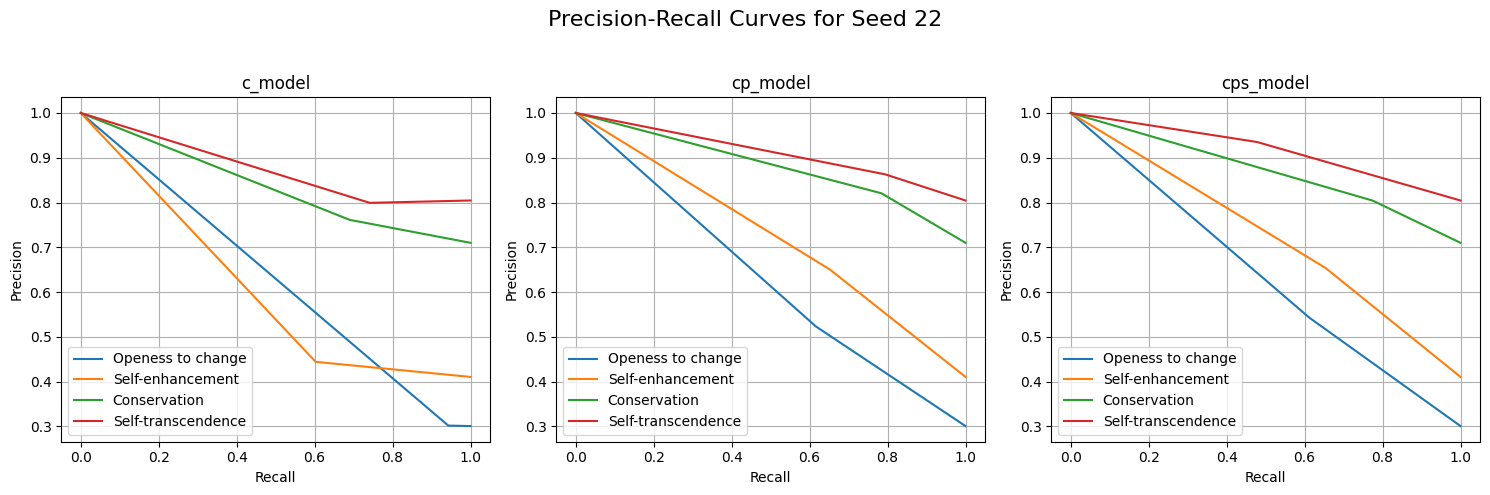

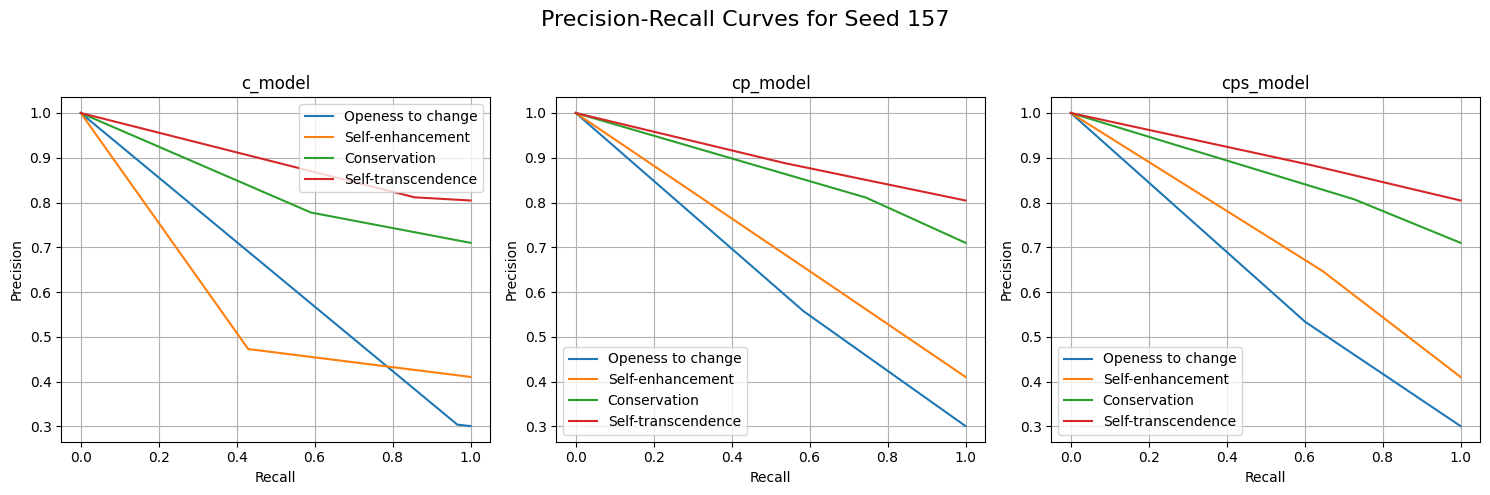

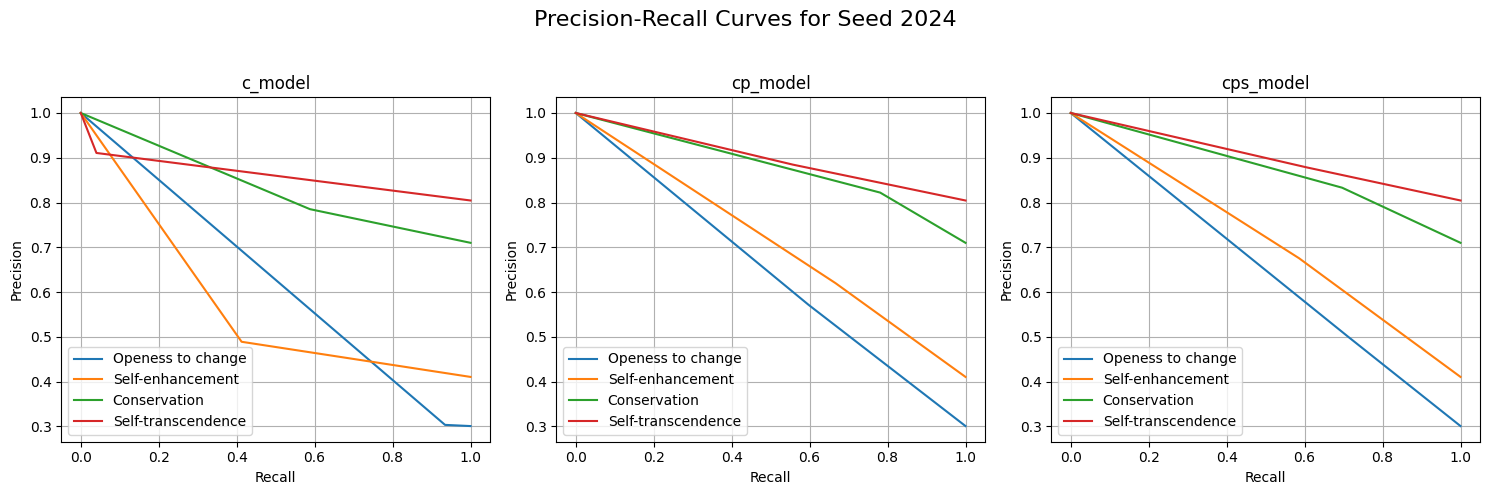

In [42]:
models = ['c_model', 'cp_model', 'cps_model']

for seed in seeds:
    # Create a new figure for each seed
    fig, axs = plt.subplots(1, len(models), figsize=(15, 5))
    fig.suptitle(f'Precision-Recall Curves for Seed {seed}', fontsize=16)
    
    # Iterate over models
    for idx, m in enumerate(models):
        y_pred = y_preds[f'{m}_{seed}']
        
        # Plot precision-recall curves for each label in the same subplot
        for i, label in enumerate(labels):
            precision, recall, _ = precision_recall_curve(labels_test[:, i], y_pred[:, i])
            axs[idx].plot(recall, precision, label=label)
        
        axs[idx].set_xlabel('Recall')
        axs[idx].set_ylabel('Precision')
        axs[idx].set_title(f'{m}')
        axs[idx].legend(loc='best')
        axs[idx].grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

**Seed 22**

- **c_model**: The precision-recall curves for this model show that the "Openness to change" and "Self-enhancement" classes have poor performance, as indicated by their rapid drop in precision as recall increases. The "Conservation" and "Self-transcendence" classes perform better, maintaining higher precision even at higher recall values.

- **cp_model**: Compared to `c_model`, the `cp_model` exhibits slightly better performance for all classes, particularly for "Self-transcendence," which maintains high precision across a wide range of recall. The "Openness to change" class still shows poor performance, although it is somewhat improved over `c_model`.

- **cps_model**: This model shows the best overall performance among the three models for Seed 22. The curves for all classes are consistently above those of the other models, indicating that `cps_model` achieves a better balance of precision and recall. The "Self-transcendence" class performs especially well, maintaining high precision across nearly all recall values.

**Seed 157**

- **c_model**: The performance is similar to that seen with Seed 22. "Openness to change" continues to perform poorly, while "Self-transcendence" and "Conservation" maintain better precision. However, "Self-enhancement" shows a drop in performance with this seed, with a more rapid decline in precision.

- **cp_model**: There is an improvement in performance for most classes compared to `c_model`, similar to what was observed with Seed 22. The "Self-transcendence" class performs particularly well, showing a stable precision across most recall values. The performance of the "Openness to change" class, while improved, still lags behind other classes.

- **cps_model**: This model again shows superior performance across all classes, particularly for "Self-transcendence," which maintains very high precision across nearly all recall levels. The "Openness to change" class still has lower performance but is better than in the other models.

**Seed 2024**

- **c_model**: The trends remain consistent with previous seeds. "Openness to change" continues to show poor performance, while "Self-transcendence" and "Conservation" show better precision-recall balance. There is a significant drop in precision for "Openness to change" as recall increases.

- **cp_model**: The model shows improved performance over `c_model` across all classes, similar to what is observed in the other seeds. "Self-transcendence" consistently performs well, while "Openness to change" remains the weakest.

- **cps_model**: As in the previous seeds, `cps_model` performs the best overall. All classes, including "Openness to change," show better precision-recall trade-offs compared to the other models. "Self-transcendence" continues to maintain very high precision across a broad range of recall values.

**General Observations**

- Across all seeds, the `cps_model` consistently outperforms both `c_model` and `cp_model`, particularly for the "Self-transcendence" class, which maintains high precision across a wide range of recall values.
- The "Openness to change" class is consistently the most challenging to predict with high precision across all models and seeds, indicating a potential area for model improvement.
- Variations in performance across seeds highlight the influence of random initialization on the models, although the general trends remain consistent.

### Confusion matrices for the BERT Models
In this section, we display confuson matrices for the three models.

The analysis of the three models — c_model, cp_model, and cps_model — across different seeds (22, 157, and 2024) reveals consistent performance with high accuracy across various matrices. All three models demonstrate **strong generalizability and reliability**, with most predictions being correct. However, a recurring issue of minor misclassification is observed across all models and seeds. Despite this, the misclassifications do not significantly affect the overall robustness of the models.

Overall, all three models are strong performers, with **cps_model** slightly edging out in terms of consistent robustness across different seeds, as we have seen before.

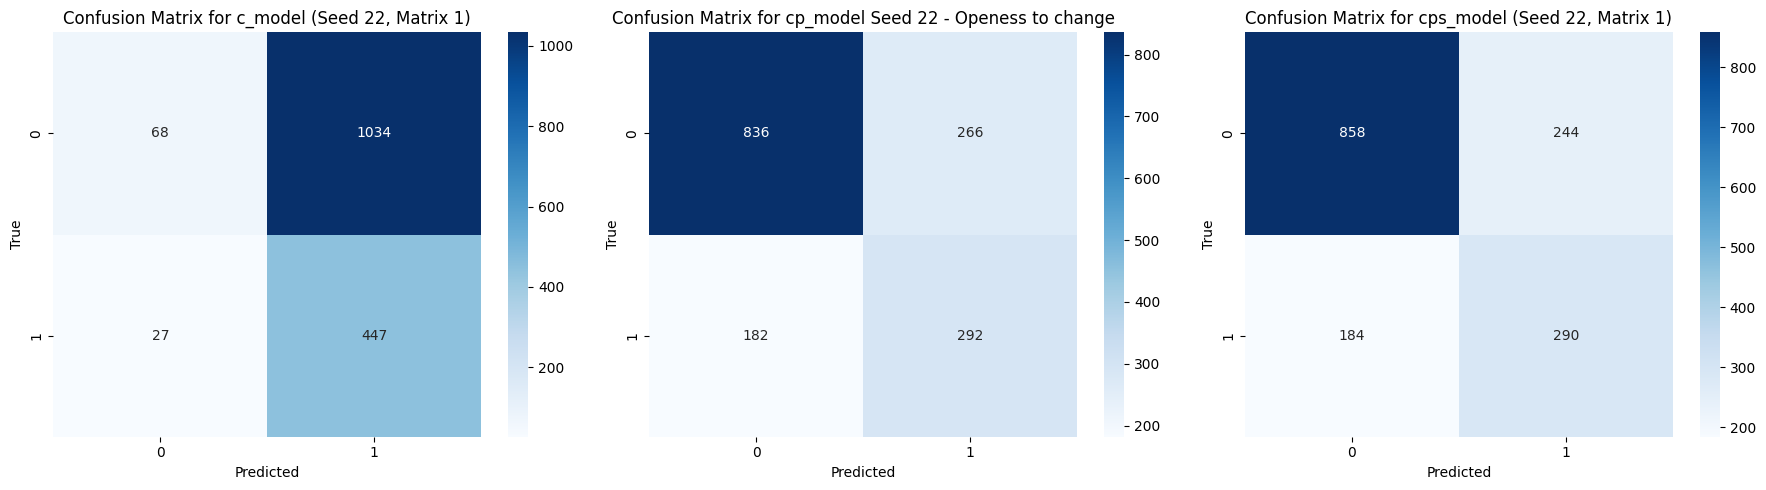

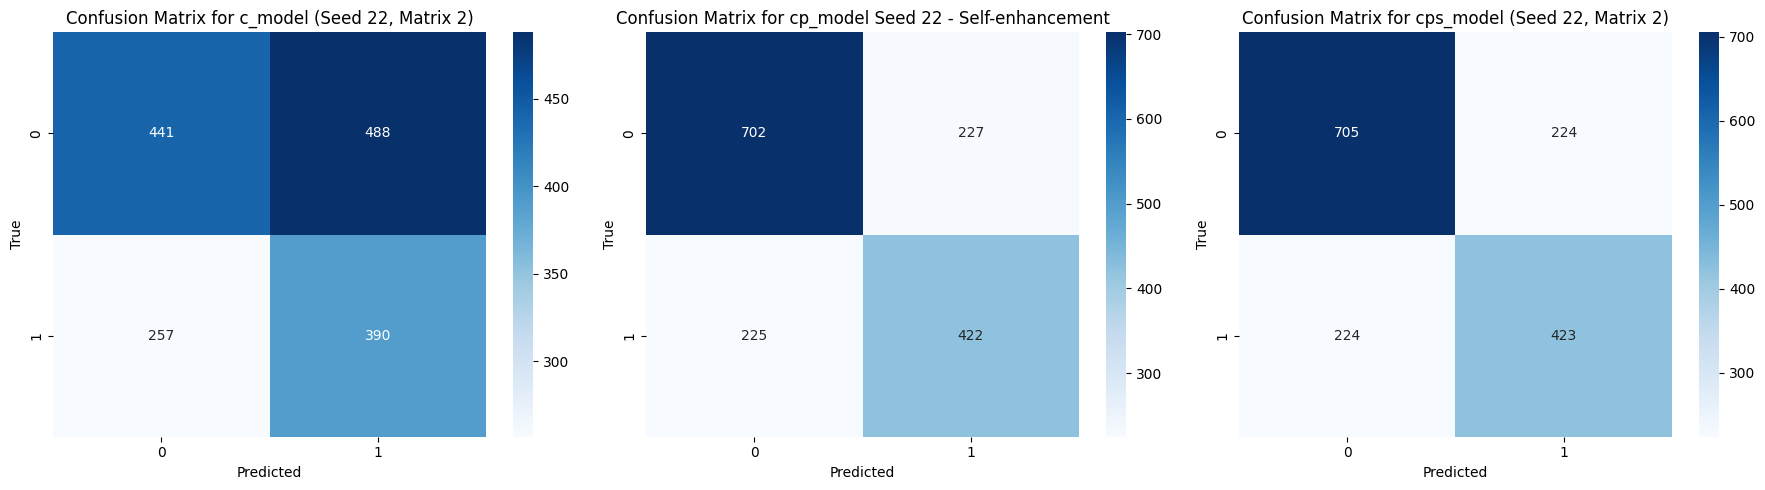

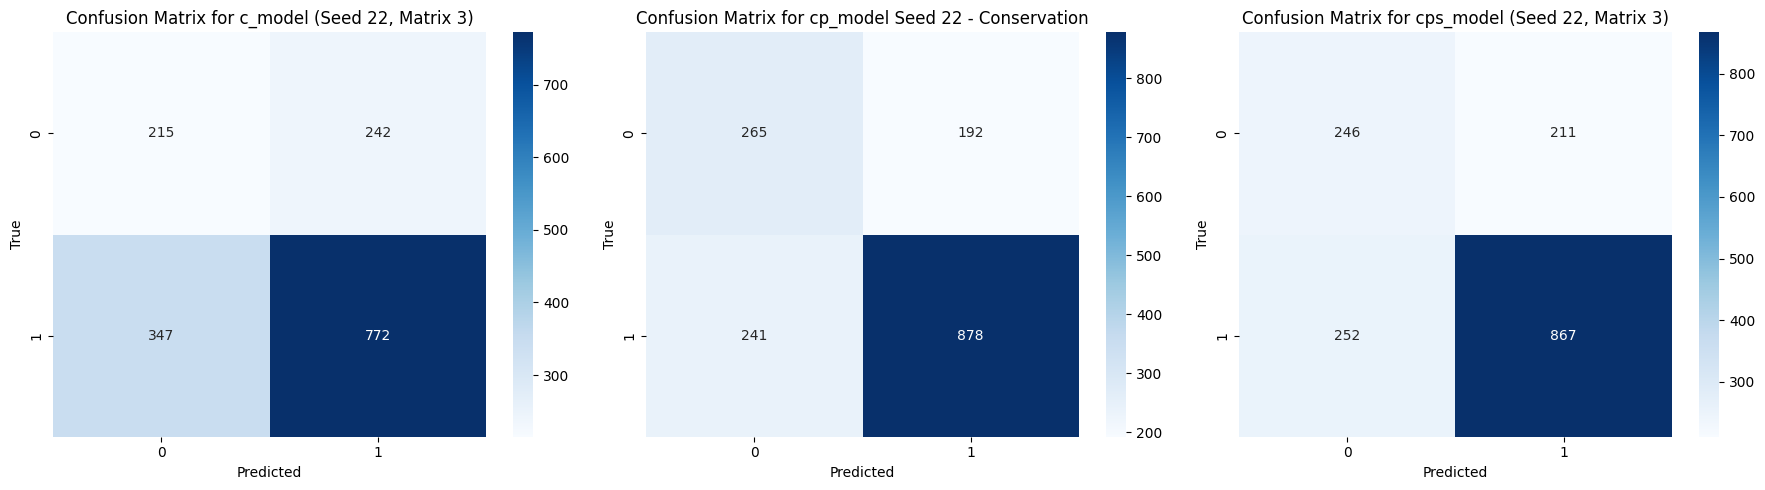

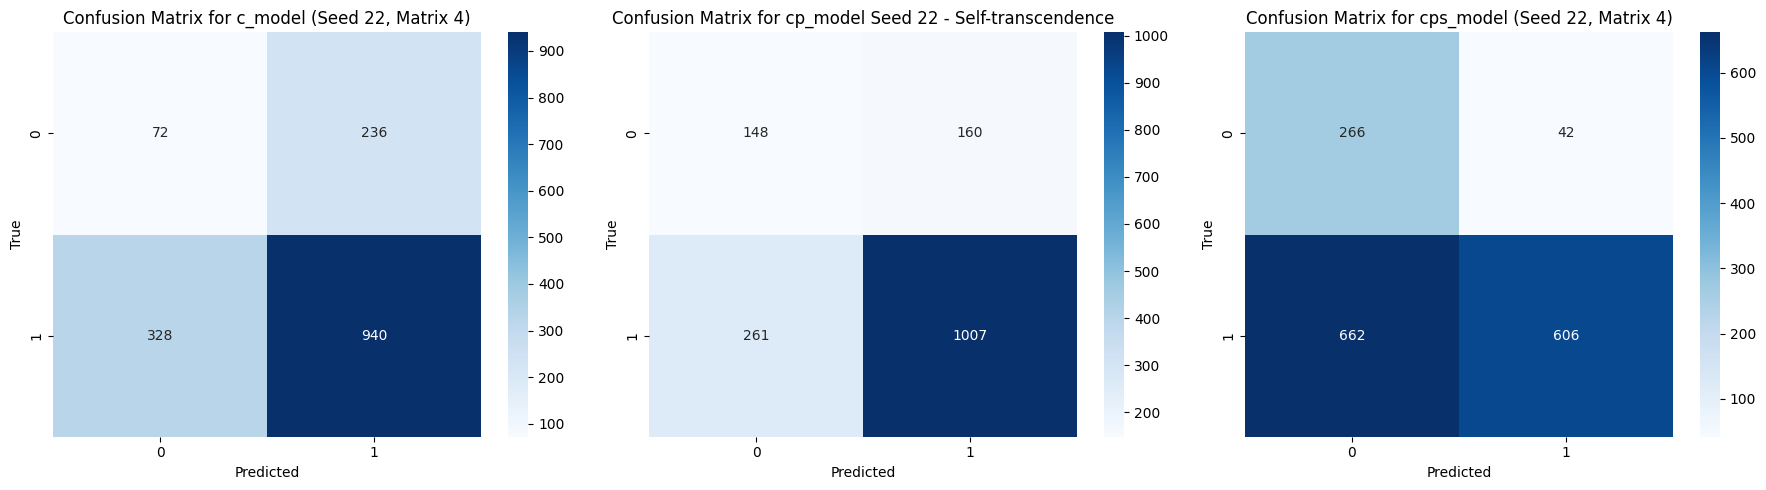

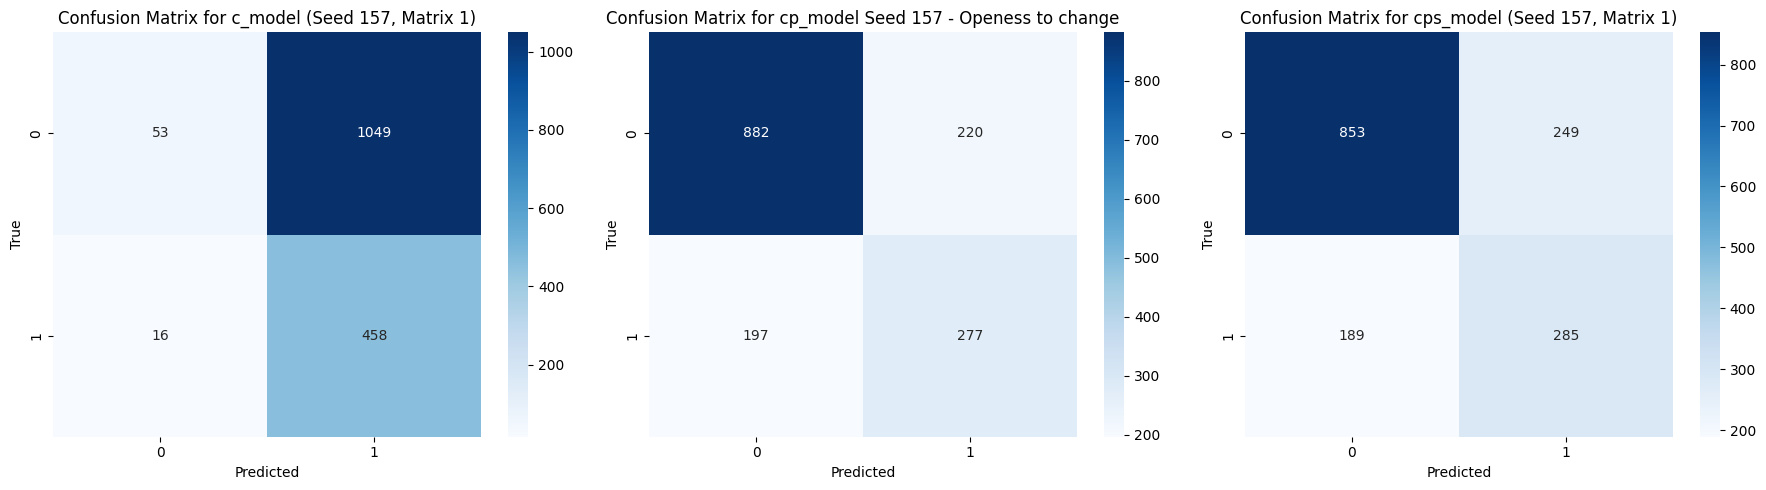

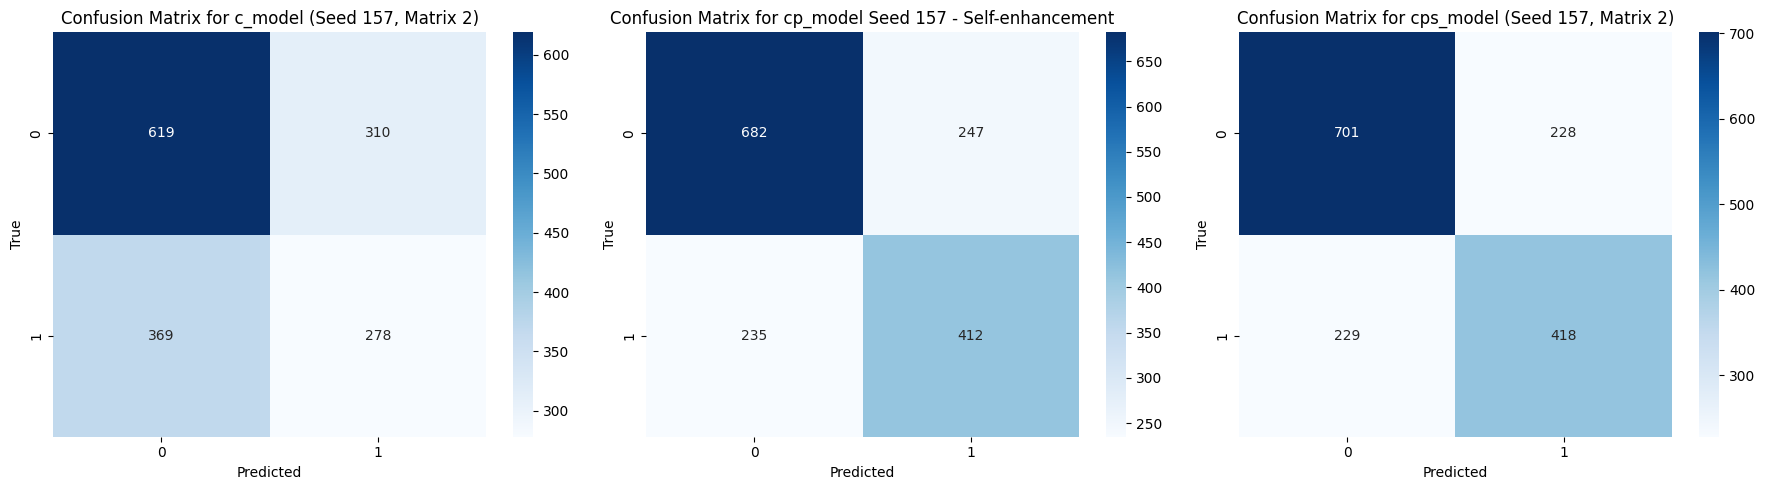

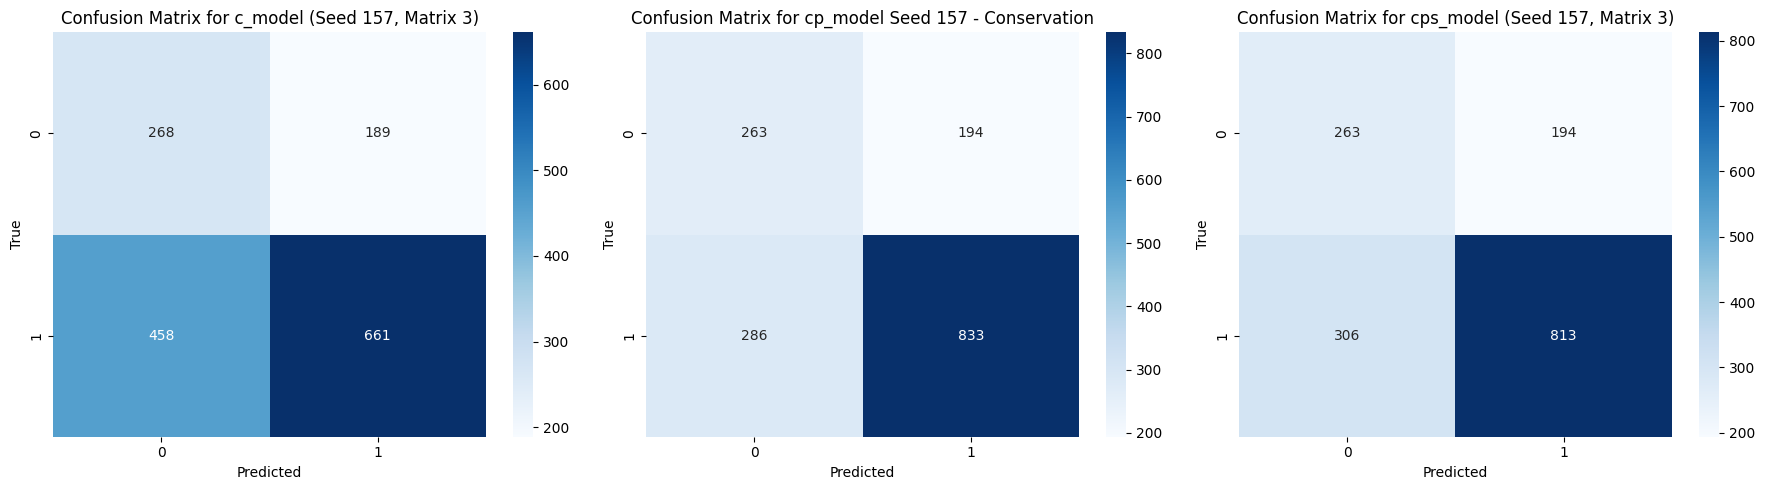

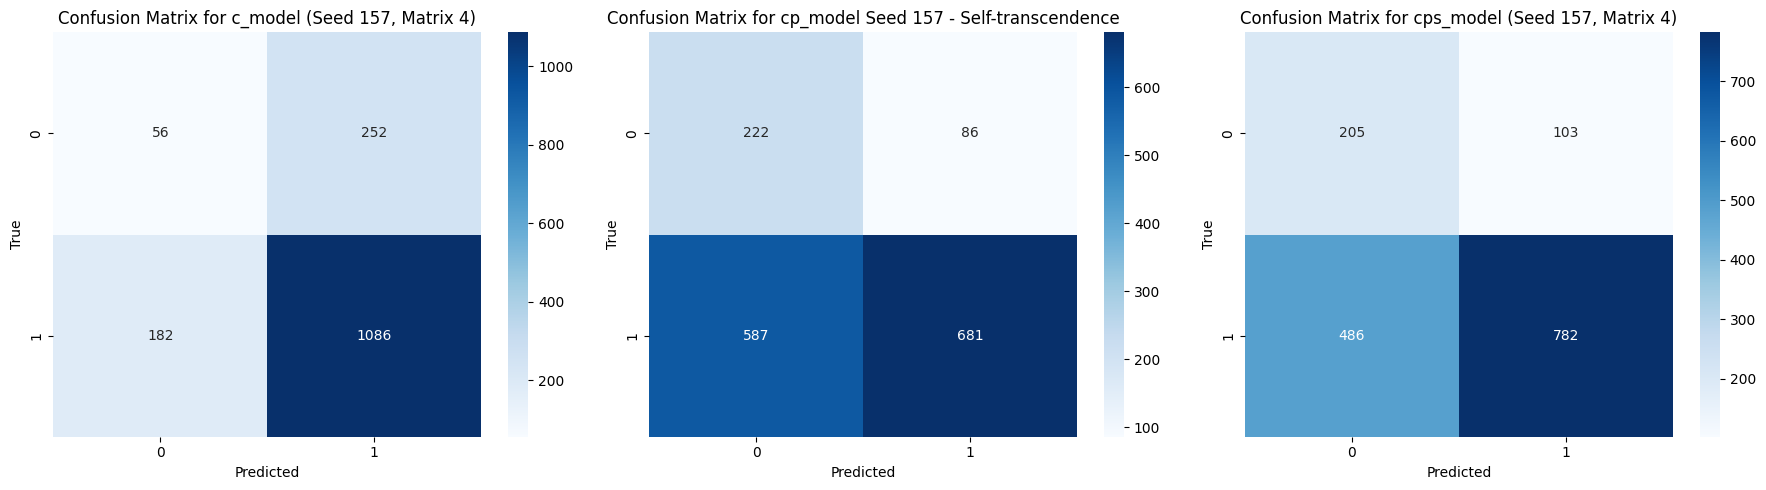

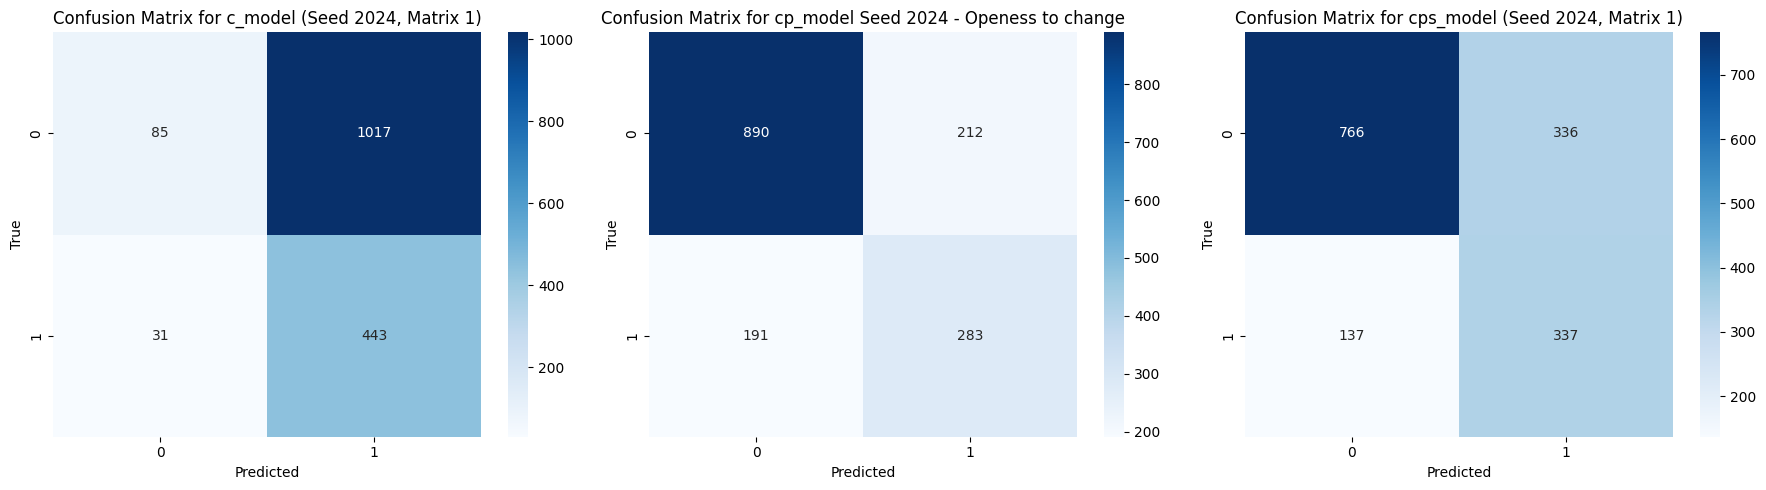

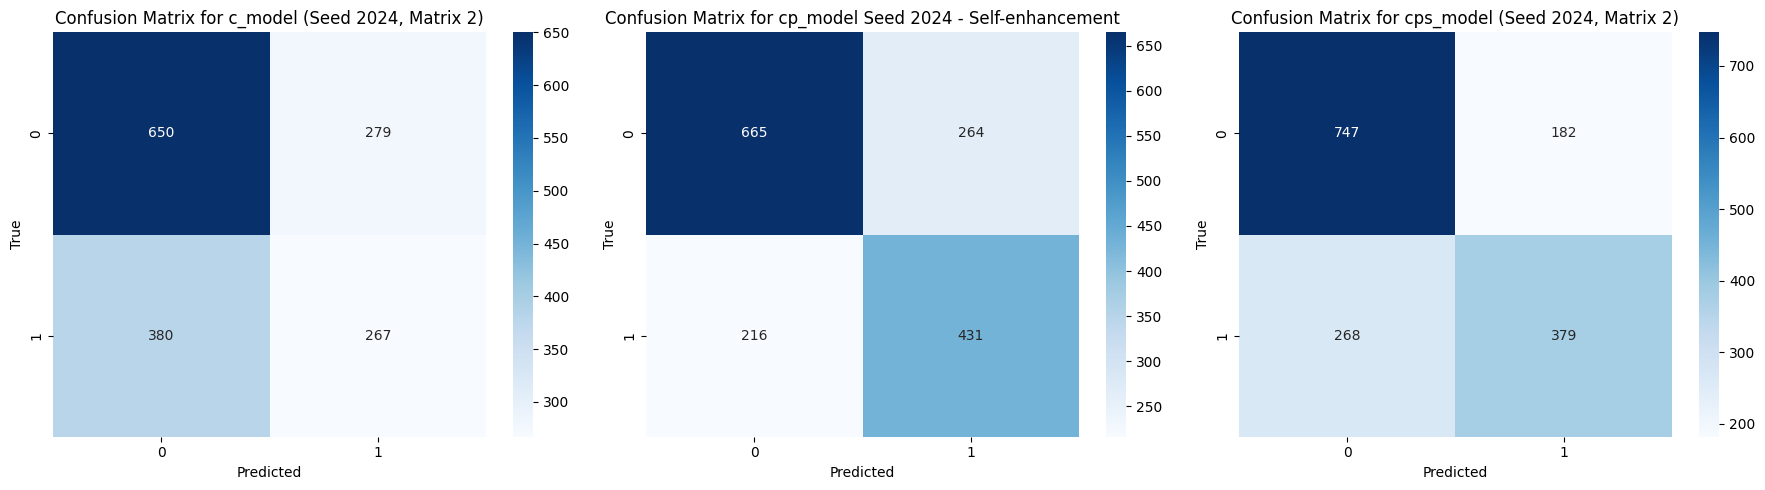

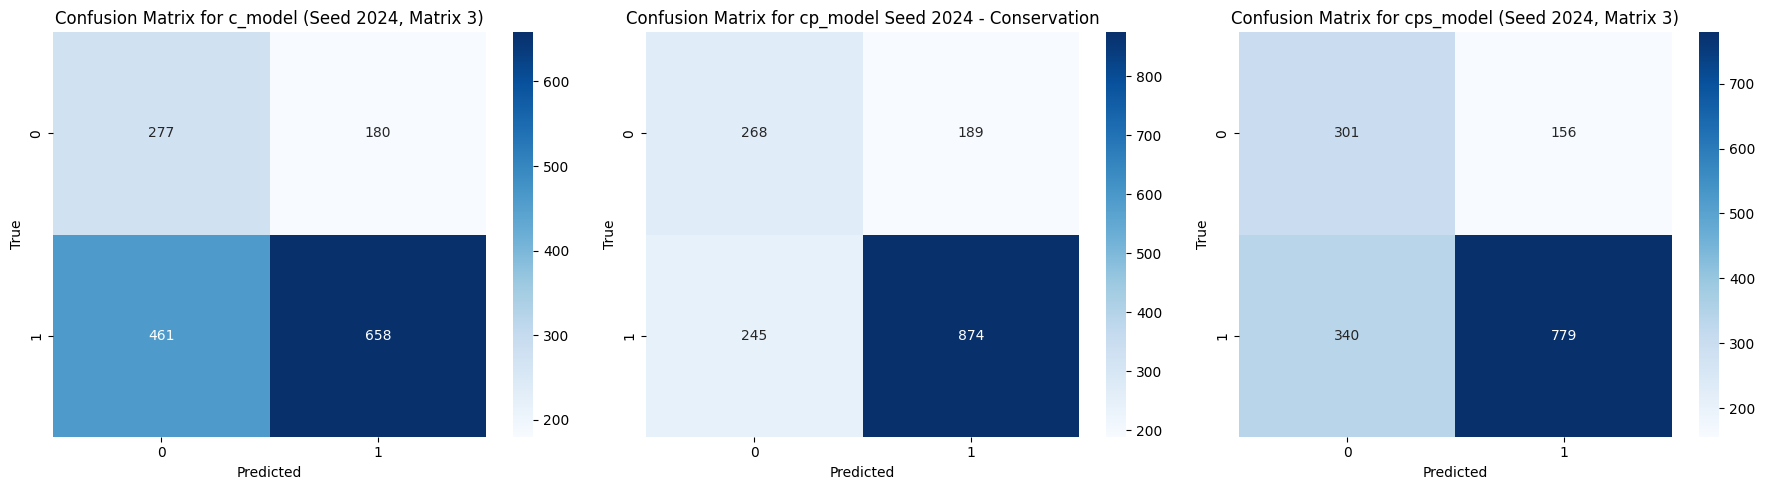

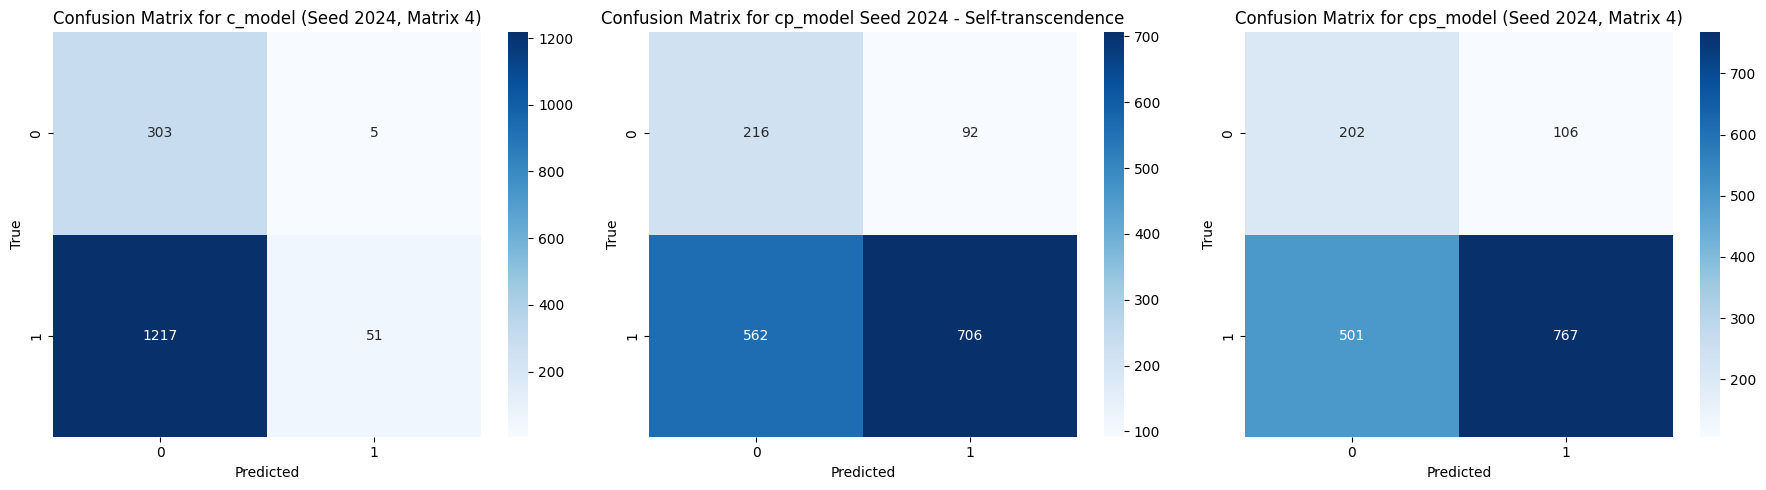

In [43]:
for seed in seeds:
    # Get the confusion matrices for each model
    c_matrices = confusion_matrixes[f'c_model_{seed}']
    cp_matrices = confusion_matrixes[f'cp_model_{seed}']
    cps_matrices = confusion_matrixes[f'cps_model_{seed}']
    
    num_matrices = len(c_matrices)
    
    for i in range(num_matrices):
        # Plot the confusion matrices
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        sns.heatmap(c_matrices[i], annot=True, fmt='d', cmap='Blues', ax=axes[0])
        axes[0].set_title(f'Confusion Matrix for c_model (Seed {seed} - {labels[i]}')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('True')
        
        sns.heatmap(cp_matrices[i], annot=True, fmt='d', cmap='Blues', ax=axes[1])
        axes[1].set_title(f'Confusion Matrix for cp_model Seed {seed} - {labels[i]}')
        axes[1].set_xlabel('Predicted')
        axes[1].set_ylabel('True')
        
        sns.heatmap(cps_matrices[i], annot=True, fmt='d', cmap='Blues', ax=axes[2])
        axes[2].set_title(f'Confusion Matrix for cps_model (Seed {seed} - {labels[i]}')')
        axes[2].set_xlabel('Predicted')
        axes[2].set_ylabel('True')
        
        plt.tight_layout()
        plt.show()
        

### Misclassification Analysis

In this section, we analyze the misclassifications for each model by comparing the predicted labels with the true labels.

For each model, we calculate the number of misclassifications for each label and the total number of errors. Then we print some examples.

The cp_model and cps_model variants outperform the c_model in terms of fewer misclassifications, indicating better overall performance. However, all models exhibit struggles with specific labels, particularly label 3, which has the highest error rates in most cases. This highlights the need for further refinement to address these label-specific challenges and improve accuracy.

In [58]:
misclassifications = {model_name: np.zeros(Y_true.shape[1], dtype=int) for model_name in y_preds.keys()}

for model_name, y_pred in y_preds.items():
    # Calculate misclassifications for each label
    misclassifications[model_name] = np.sum(Y_true != y_pred, axis=0)

    # Calculate total number of misclassifications
    total_errors = np.sum(misclassifications[model_name])
    
    print(f"\nTotal misclassifications for {model_name}: {total_errors}")
    
    # Print misclassifications for each label
    for label_idx in range(Y_true.shape[1]):
        print(f"Errors for label {label_idx}: {misclassifications[model_name][label_idx]}")

    # Find indices of misclassified samples
    error_indices = np.where(np.any(Y_true != y_pred, axis=1))[0]
    
    # Print misclassified samples with original rows
    print(f"\nMisclassification examples for {model_name}:")
    for i in [22, 157, 325]:
        print(f"\nPred: {y_pred[i]}, True: {Y_true[i]}, Original Row: {df_test.iloc[i].to_dict()}")
    print(f"\n----------------------------")


Total misclassifications for c_model_22: 2959
Errors for label 0: 1061
Errors for label 1: 745
Errors for label 2: 589
Errors for label 3: 564

Misclassification examples for c_model_22:

Pred: [1. 1. 0. 0.], True: [0 1 1 1], Original Row: {'Conclusion': 'We should end affirmative action', 'Stance': '0', 'Premise': 'affirmative action is necessary to make up for the wrongs inflicted on minorities', 'Openess to change': 0, 'Self-enhancement': 1, 'Conservation': 1, 'Self-transcendence': 1, 'Conclusion_Length': 32, 'Premise_Length': 81, 'Values_Vector': [0, 1, 1, 1]}

Pred: [1. 0. 1. 1.], True: [1 0 1 0], Original Row: {'Conclusion': 'We should abandon marriage', 'Stance': '0', 'Premise': 'marriage should be allowed as it an important religious idea.', 'Openess to change': 1, 'Self-enhancement': 0, 'Conservation': 1, 'Self-transcendence': 0, 'Conclusion_Length': 26, 'Premise_Length': 61, 'Values_Vector': [1, 0, 1, 0]}

Pred: [1. 0. 1. 1.], True: [0 1 1 0], Original Row: {'Conclusion': 'W